In [3]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import skimage
import pickle

from config import Config
import utils
import model as modellib
import visualize
from model import log
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/camila/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [3]:
class JetsDataset(utils.Dataset):
    """
    ...
    """

    def load_data(self, m, images, labels):
        self.add_class('jets', 1, 'jet')
        
        for i in range(m):
            image = images[i,:,:].reshape(64,64)
            label = labels[i,:,:].reshape(64,64)
            self.add_image('jets', i, path=None, image=image, label=label)
        
    
    def load_image(self, image_id):
        """
        Returns the input image
        """
        info = self.image_info[image_id]
        image = info['image']
        
        image = np.round(image * (255/np.max(image)))
        
        image3D = np.zeros((image.shape[0], image.shape[1], 3))
        image3D[:,:,0] = image
        image3D[:,:,1] = image
        image3D[:,:,2] = image

        image3D = image3D.astype(np.uint8)
        
        return image3D
        

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "jets":
            return info["image"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        label = info['label']
        shape = label.shape
        num_jets = np.max(label).astype(int)
        masks = np.zeros((shape[0], shape[1], num_jets)).astype(np.int32)
        
        for i in range(num_jets):
            masks[:,:,i] = (label == i+1)
                      
        class_ids = np.ones(num_jets, dtype=np.int32)
        
        return masks, class_ids

In [38]:
images_val= np.load('pixel_image_pt.npy')[99000:, :, :]

labels_val= np.load('labels_20pt.npy')[99000:, :, :]

m_val = images_val.shape[0]
dataset_val = JetsDataset()
dataset_val.load_data(m_val, images_val, labels_val)
dataset_val.prepare()

In [39]:
print(images_val.shape)
print(labels_val.shape)

(1000, 64, 64)
(1000, 64, 64)


In [6]:
class JetsConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "jets"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    
    # No mini-masks
    USE_MINI_MASK = False

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (4, 8, 16, 32, 64)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32
    #XXXXXXXXXXXXXXXXXXX Change?

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = JetsConfig()
#config.display()

In [7]:
class InferenceConfig(JetsConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")

#model_path = model.find_last()[1]
model_path = "/home/camila/cs230/Jets_20pt_Train_fixedLabels/logs/jets20180610T1259/mask_rcnn_jets_1990.h5"

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/camila/cs230/Jets_20pt_Train_fixedLabels/logs/jets20180610T1259/mask_rcnn_jets_1990.h5


In [8]:
## get number of jets and pT of jets from ground truth label and image
'''returns true number of jets (int) and a list with the true pT of jets'''
def gt_Njets_pT(label, image):
    gt_n_jets = int(np.amax(label))
    gt_pT_jets = []
    
    if gt_n_jets == 0:
        return(gt_n_jets, gt_pT_jets) 
        
    for i in range(1, gt_n_jets + 1):
        result = np.sum(np.multiply(label == i, image))            
        gt_pT_jets.append(result)

    return(gt_n_jets, gt_pT_jets)

In [43]:
def make_cmat(cmat, title):
    plt.figure()
    plt.imshow(cmat)
    plt.ylabel('true number of jets')
    plt.xlabel('predicted number of jets')
    plt.title(title)
    plt.colorbar()
    plt.savefig(title + '_cmat.png', bbox_inches='tight', dpi = 600)
    plt.show()

image id: 851
image id: 851


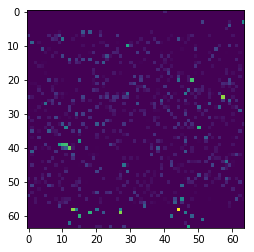

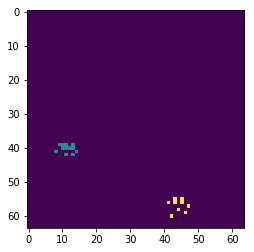

<Figure size 432x288 with 0 Axes>

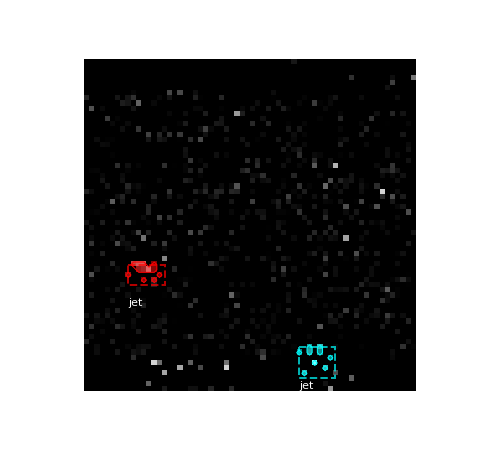

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  255.00000
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  151.10000
image_metas              shape: (1, 10)               min:    0.00000  max:   64.00000


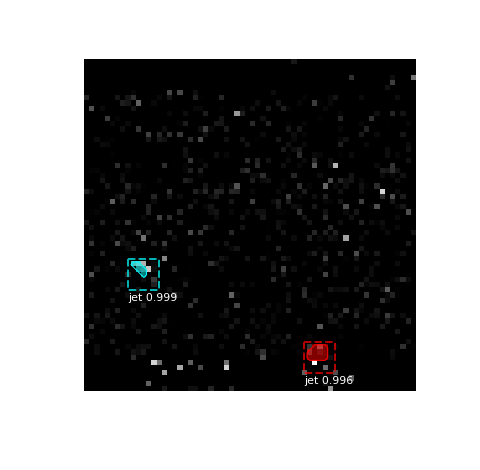

In [10]:
# Load and display random example from validation set
image_id = random.choice(dataset_val.image_ids)
print('image id: ' + str(image_id))
image = dataset_val.load_image(image_id)
mask, class_ids = dataset_val.load_mask(image_id)
plt.imshow(image)

print('image id: ' + str(image_id))
plt.imshow(images_val[image_id])
plt.savefig('figures/' + str(image_id) + '_raw.png')
plt.figure()
plt.imshow(labels_val[image_id])
plt.savefig('figures/' + str(image_id) + '_label.png')
plt.figure()

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

model_fn = 'figures/' + str(image_id) + '_model.png'    
pred_fn = 'figures/' + str(image_id) + '_pred.png'    
    
visualize.display_instances(model_fn, original_image, gt_bbox, gt_mask, gt_class_id, dataset_val.class_names, figsize=(8, 8))

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(pred_fn, original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, scores = r['scores'], ax=get_ax())



In [11]:
 def getResults(pT_min, pred_score_min, cmat_dim, dataset_val):

        val_results = {}
        cmat = np.zeros((cmat_dim, cmat_dim))

        gt_n_jets_list = []
        gt_pT_jets_list = []
        gt_bbox_jets_list = []
        gt_n_jets_list_2 = []
        gt_pT_jets_list_2 = []

        pred_n_jets_list = []
        pred_pT_jets_list = []
        pred_bbox_jets_list = []

        for image_id in dataset_val.image_ids:
            if image_id % 200 == 0:
                print(image_id)

            image = images_val[image_id]
            label = labels_val[image_id]

            ## get ground truths pT and number of jets
            gt_n_jets, gt_pT_jets = gt_Njets_pT(label, image)
            gt_n_jets_list.append(gt_n_jets)
            gt_pT_jets_list.append(gt_pT_jets)

            ## make model instance with image    
            original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config, 
                                       image_id, use_mini_mask=False)

            ## get ground truth bounding boxes, also getting calculated pT and n_jets from bbox*image product
            bbox_jets_image = []
            pT_jets_image = []

            if gt_n_jets > 0:
                for i in range(gt_n_jets):
                    y1, x1, y2, x2 = gt_bbox[i]
                    pT_jets_image.append(np.sum(image[y1:(y2), x1:(x2)]))
                    bbox_jets_image.append([y1, x1, y2, x2])

            gt_n_jets_list_2.append(gt_n_jets)
            gt_pT_jets_list_2.append(pT_jets_image)
            gt_bbox_jets_list.append(bbox_jets_image)

            ## do prediction
            results = model.detect([original_image], verbose=0)
            r = results[0]

            ## get predicted pT, n jets, bbox
            pT_jets_pred = []
            n_jets_pred = r['rois'].shape[0]
            n_jets_filtered = 0
            bbox_jets_pred = []

            if n_jets_pred > 0:
                for j in range(n_jets_pred):
                    y1, x1, y2, x2 = r['rois'][j]
                    pT_jet = np.sum(image[y1:(y2+1), x1:(x2+1)])

                    if pT_jet >= pT_min and r['scores'][j] >= pred_score_min:
                        pT_jets_pred.append(pT_jet)
                        bbox_jets_pred.append([y1, x1, y2, x2])
                        n_jets_filtered += 1

                pT_jets_pred.sort(reverse = True)

            pred_n_jets_list.append(n_jets_filtered)
            pred_pT_jets_list.append(pT_jets_pred)
            pred_bbox_jets_list.append(bbox_jets_pred)

            ## confusion matrix         
            if gt_n_jets >= cmat_dim:
                gt_n_jets = cmat_dim - 1
            if n_jets_filtered >= cmat_dim:
                n_jets_filterd = cmat_dim - 1

            cmat[gt_n_jets, n_jets_filtered] += 1 
        
        val_results = {'gt_n' : gt_n_jets_list, 'gt_pT' : gt_pT_jets_list, 'pred_n' : pred_n_jets_list, 'pred_pT': pred_pT_jets_list, 'cmat' : cmat}
        
        return val_results

In [14]:
## Run this cell to get predictions from validation dataset. 
## NOTE: load dictionary in cell below to avoid running this cell

pT_min = 20
pred_score_min = [0.9, 0.91, 0.92, .93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
cmat_dim = 6

dict_weights1990_res = {}

for pred_score in pred_score_min:
    pred_dic = getResults(pT_min, pred_score, cmat_dim, dataset_val)
    dict_weights1990_res['pred_score_' + str(pred_score)] = pred_dic
   

0
200
400
600
800
0
200
400
600
800
0
200
400
600
800
0
200
400
600
800
0
200
400
600
800
0
200
400
600
800
0
200
400
600
800
0
200
400
600
800
0
200
400
600
800
0
200
400
600
800


In [4]:
## Load dictionary containing results of cell above
## dict_weights1990_res contains a series of dictionaries varying the prediction threshold score 
## from 0.9 to 0.99
## Each subdictionary contains 4 keys:
## 'gt_n': ground truth number of jets. Value is a list of integers going from event 0 to 999 in val set
## 'gt_pT': ground truth number of jets. Value is a list of lists with true pT. pT are sorted from high to low.
## 'pred_n': predicted number of jets. Value is a list of integers going from event 0 to 999 in val set
## 'pred_pT': predicted pT of jets. They are sorted by pT from high to low.
## 'cmat': confusion matrix


dict_weights1990_res = pickle.load( open( "dict_weights1990_scores.pkl", "rb" ) )

In [7]:
dict_weights1990_res['pred_score_0.9'].keys()

dict_keys(['gt_n', 'gt_pT', 'pred_n', 'pred_pT', 'cmat'])

In [28]:
def plotNjets_Cases(pred_dict, title, s = 2): 
    
    tp_x = []
    tp_y = []
    tn_x = []
    tn_y = []
    fp_x = []
    fp_y = []
    fn_x = []
    fn_y = []
    fp_x0 = []
    fp_y0 = []
    
    gt_n_jets_list = pred_dict['gt_n']
    pred_n_jets_list = pred_dict['pred_n']
    gt_pT_jets_list = pred_dict['gt_pT']
    pred_pT_jets_list = pred_dict['pred_pT']

    for image_id in dataset_val.image_ids:
        n_true = gt_n_jets_list[image_id]
        n_pred = pred_n_jets_list[image_id]
        pT_true = gt_pT_jets_list[image_id]
        pT_pred = pred_pT_jets_list[image_id]

        if n_true > 0:
            if n_true == n_pred:
                tp_x.append(max(pT_true))
                tp_y.append(n_pred/n_true)
            else: 
                if n_pred > 0:
                    fp_x.append(max(pT_true)) 
                    fp_y.append(n_pred/n_true)
                else:
                    fp_x0.append(0)
                    fp_y0.append(0)

        else:
            if n_pred == 0:
                tn_x.append(0)
                tn_y.append(0)
            else:
                fn_x.append(max(pT_pred))
                fn_y.append(-n_pred)

    plt.figure()
    plt.scatter(tp_x, tp_y, s = s, label = 'TP: ' + str(len(tp_x)))
    plt.scatter(tn_x, tn_y, s = s, label = 'TN: ' + str(len(tn_x)))
    plt.scatter(fp_x, fp_y, s = s, label = 'FP: ' + str(len(fp_x)))
    plt.scatter(fn_x, fn_y, s = s, label = 'FN: ' + str(len(fn_x)))
    plt.scatter(fp_x0, fp_y0, s = s, label = 'FP_0: ' + str(len(fp_x0)))
    plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), fontsize = 14)
    plt.xlabel('pT', size = 14)
    plt.ylabel('$N_{pred}$/$N_{true}$', size = 14)
    plt.title(title)
    plt.savefig(title + 'plot_Njets_cases.png', bbox_inches='tight', dpi = 600)
    plt.show()
    
    return tp_x, tp_y, tn_x, tn_y, fp_x, fp_y, fn_x, fn_y, fp_x0, fp_y0

In [29]:
def plot_pTjets_Cases(pred_dict, title, s = 2): 
    
    tp_x = []
    tp_y = []
    fp_x = []
    fp_y = []
    fp_x0 = []
    fp_y0 = []
    fn_x = []
    fn_y = []
    tn_x = []
    tn_y = []
    
    gt_n_jets_list = pred_dict['gt_n']
    pred_n_jets_list = pred_dict['pred_n']
    gt_pT_jets_list = pred_dict['gt_pT']
    pred_pT_jets_list = pred_dict['pred_pT']

    for image_id in dataset_val.image_ids:
        n_true = gt_n_jets_list[image_id]
        n_pred = pred_n_jets_list[image_id]
        pT_true = gt_pT_jets_list[image_id]
        pT_pred = pred_pT_jets_list[image_id]

        if n_true > 0:
            if n_true == n_pred:
                for i in range(n_pred):    
                    tp_x.append(pT_true[i])
                    tp_y.append(pT_pred[i])
            else:
                if n_pred > 0:
                    for i in range(min(n_true, n_pred)):   
                        fp_x.append(pT_true[i]) 
                        fp_y.append(pT_pred[i])
                else:
                    for i in range(n_true):
                        fp_x0.append(pT_true[i])
                        fp_y0.append(0)
        else:
            if n_pred > 0:
                for pT_predicted  in pT_pred:
                    fn_x.append(0)
                    fn_y.append(pT_predicted)
            else:
                tn_x.append(0)
                tn_y.append(0)

    plt.figure()
    plt.scatter(tp_x, tp_y, s = s, label = 'TP: ' + str(len(tp_x)))
    plt.scatter(tn_x, tn_y, s = s, label = 'TN: ' + str(len(tn_x)))
    plt.scatter(fp_x, fp_y, s = s, label = 'FP: ' + str(len(fp_x)))
    plt.scatter(fn_x, fn_y, s = s, label = 'FN: ' + str(len(fn_x)))
    plt.scatter(fp_x0, fp_y0, s = s, label = 'FP_0: ' + str(len(fp_x0)))
    
    plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5), fontsize = 14)
    plt.xlabel('pT true', size = 14)
    plt.ylabel('pT predicted', size = 14)
    plt.title(title)
    plt.savefig(title + 'plot_pTjets_cases.png', bbox_inches='tight', dpi = 600)
    plt.show()

In [30]:
def get_accuracy_score(pred_dict):
    
    y_true = pred_dict['gt_n']
    y_pred = pred_dict['pred_n']
    
    return accuracy_score(y_true, y_pred)  

In [35]:
def get_f1_score(pred_dict):
    
    y_true = pred_dict['gt_n']
    y_pred = pred_dict['pred_n']
    
    return f1_score(y_true, y_pred, average = 'micro')  

In [31]:
def plot_pT(pred_dict, title, s = 2):
       
    x = []
    y = []
    error = []
    
    gt_n_jets_list = pred_dict['gt_n']
    pred_n_jets_list = pred_dict['pred_n']
    gt_pT_jets_list = pred_dict['gt_pT']
    pred_pT_jets_list = pred_dict['pred_pT']

    for image_id in dataset_val.image_ids:

        n_true = gt_n_jets_list[image_id]
        n_pred = pred_n_jets_list[image_id]
        pT_true = gt_pT_jets_list[image_id]
        pT_pred = pred_pT_jets_list[image_id]

        if n_pred > n_true:
            pT_pred = pT_pred[:n_true]  

        if n_pred > 0:
            for i in range(len(pT_pred)):
                x.append(pT_true[i])
                y.append(pT_pred[i]/pT_true[i])
                error.append((pT_pred[i] - pT_true[i])/pT_true[i])

    plt.figure()
    plt.scatter(x, y, s = s)
    plt.xlabel('$pT_{true}$', size = 14)
    plt.ylabel('$pT_{predicted}$/$pT_{true}$', size = 14)
    plt.title(title)
    plt.savefig(title + 'plot_pT.png', bbox_inches='tight', dpi = 600)
    plt.show()

    plt.figure()
    plt.scatter(x, error, s = s)
    plt.xlabel('$pT_{true}$', size = 14)
    plt.ylabel('resolution', size = 14)
    plt.title(title)
    plt.savefig(title + 'plot_resolution_pT.png', bbox_inches='tight', dpi = 600)
    plt.show()

In [ ]:
def print_metrics(pred_dict, tp_x, tp_y, tn_x, tn_y, fp_x, fp_y, fn_x, fn_y, fp_x0, fp_y0): 
    
    gt_n = pred_dict['gt_n']
    pred_n = pred_dict['pred_n']
    gt_pT = pred_dict['gt_pT']
    pred_pT = pred_dict['pred_pT']
    
    
    print('true Njets: ' + str(sum(gt_n)))
    print('pred Njets: ' + str(sum(pred_n)))

    print(' ')

    #print('events predicted correctly:' + str(double(sum(tp_x)/sum, 2)))
    #print('events overestimated: ' + double(str(over/total_gt_n*100), 2))
    #print('events underestimated: ' + double(str(below/total_gt_n*100), 2))
    #print('events with no true jets:' + double(str(zero/total_gt_n*100), 2))
    #print('events no jets were predicted and there were true jets: ' + double(str(misses/total_gt_n*100), 2))

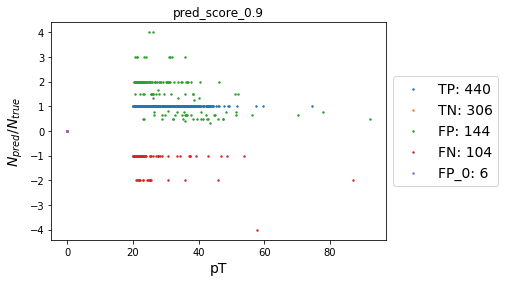

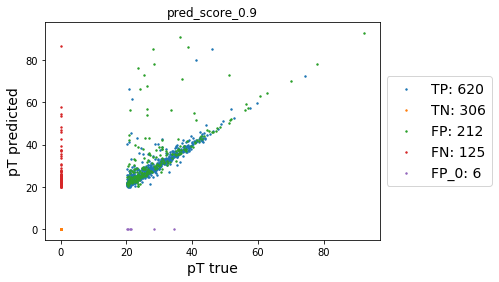

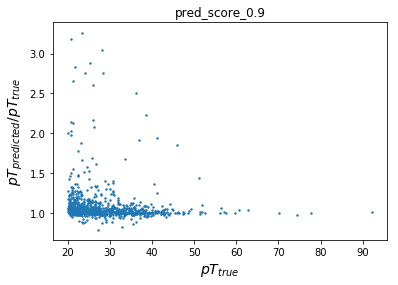

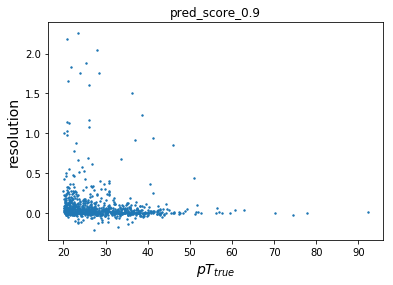

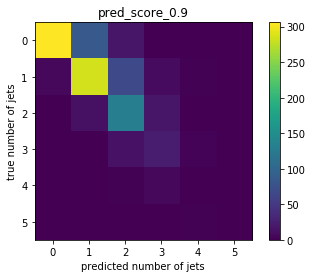

accuracy score: 0.746
F1 score: 0.746


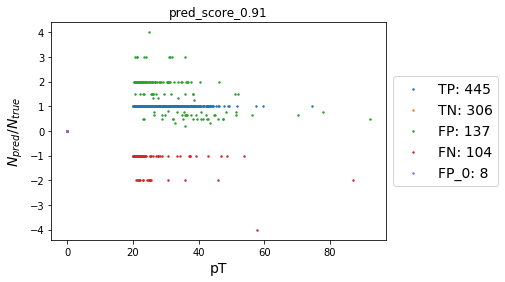

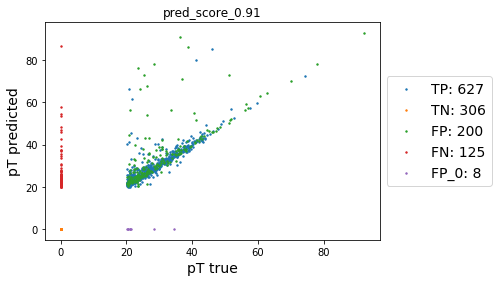

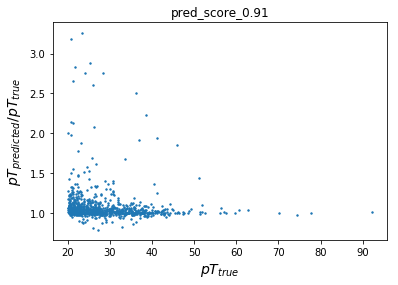

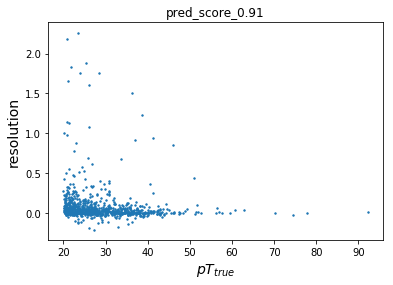

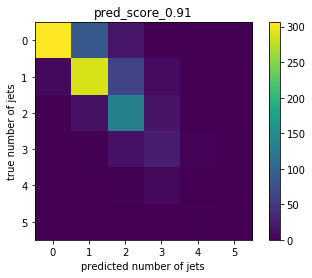

accuracy score: 0.751
F1 score: 0.751


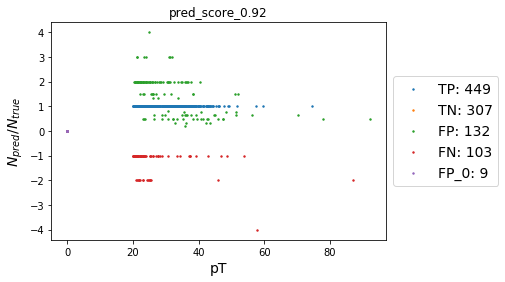

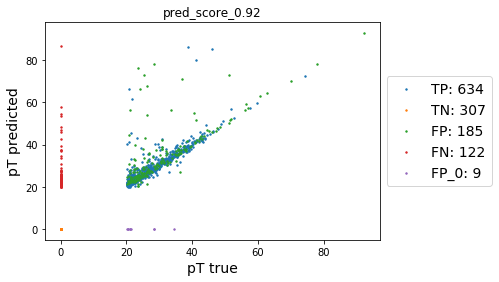

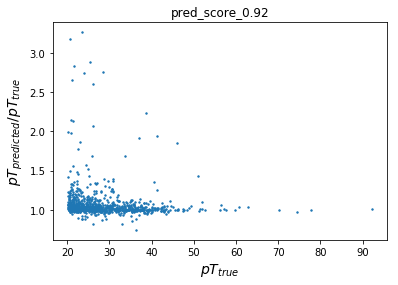

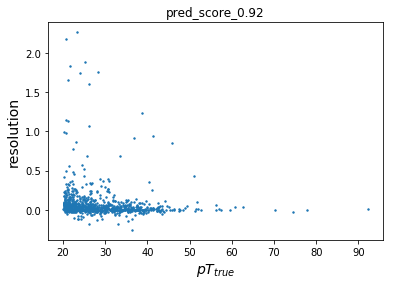

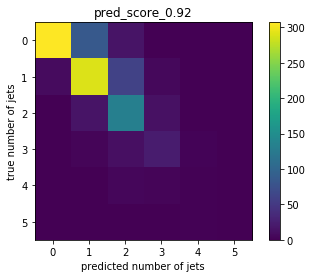

accuracy score: 0.756
F1 score: 0.756


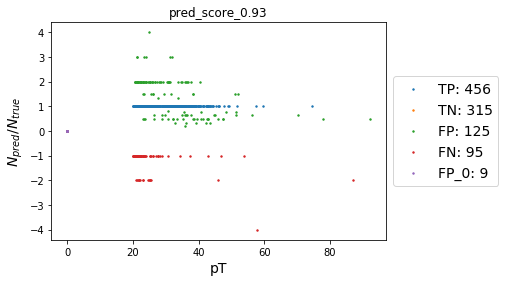

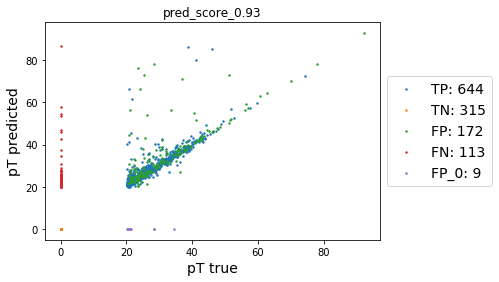

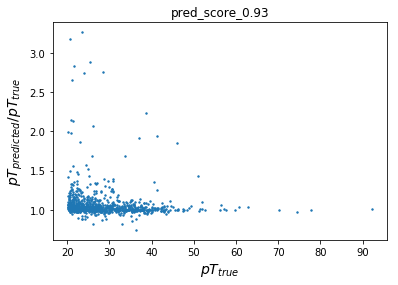

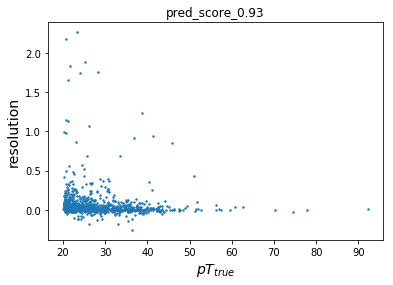

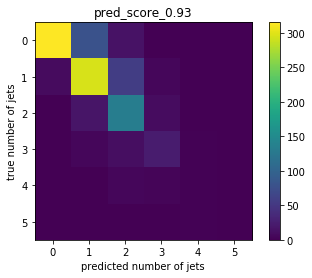

accuracy score: 0.771
F1 score: 0.771


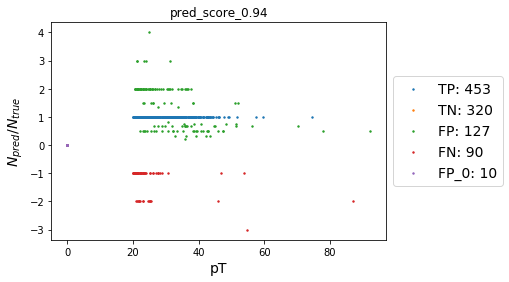

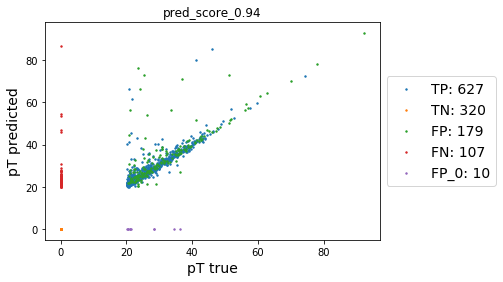

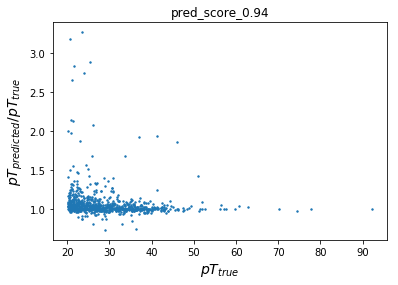

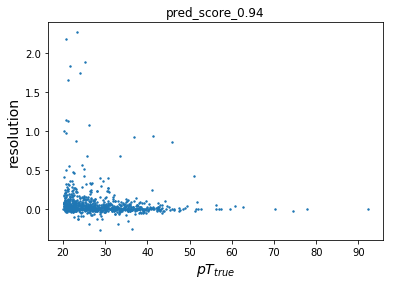

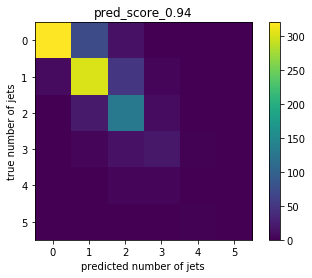

accuracy score: 0.773
F1 score: 0.7729999999999999


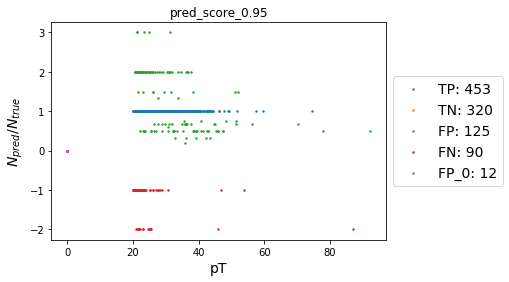

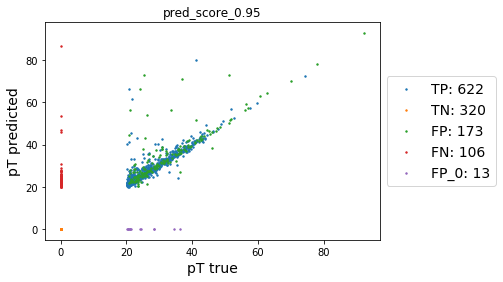

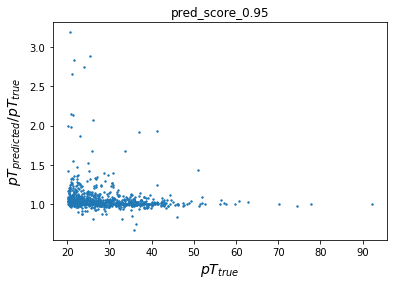

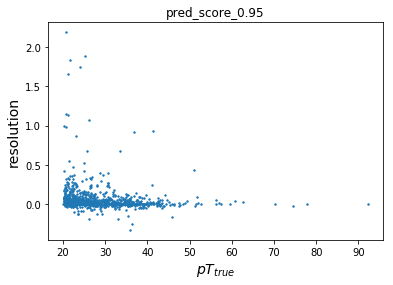

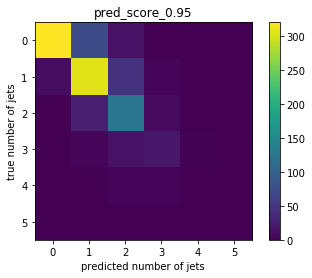

accuracy score: 0.773
F1 score: 0.7729999999999999


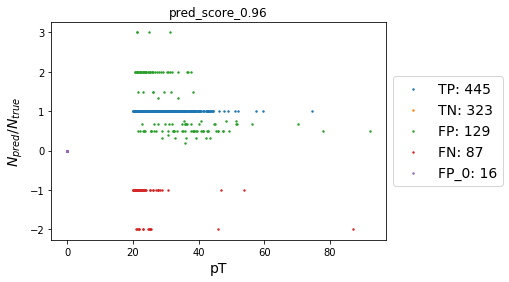

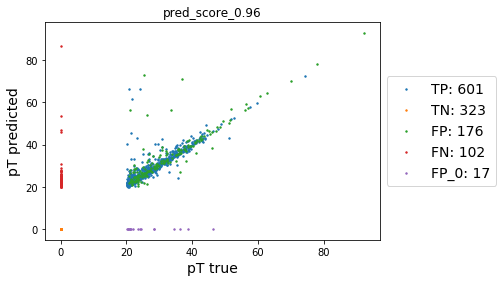

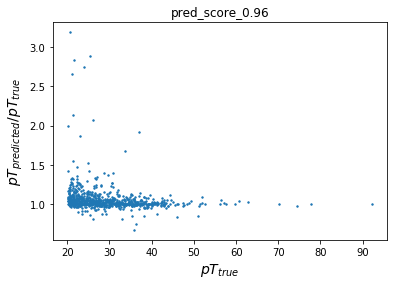

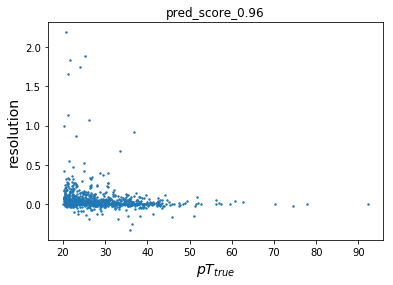

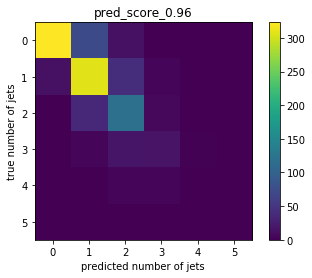

accuracy score: 0.768
F1 score: 0.768


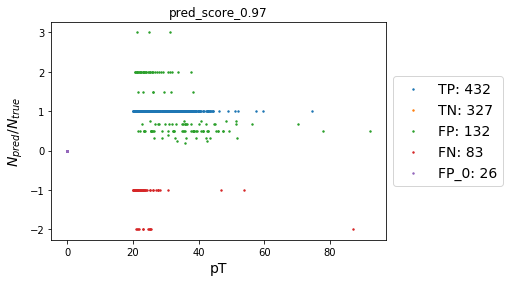

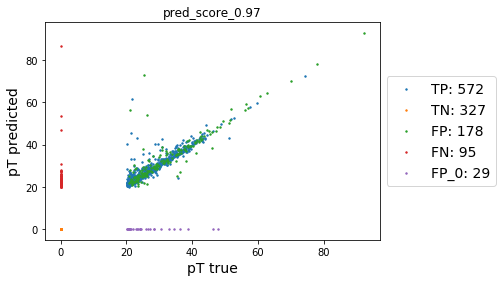

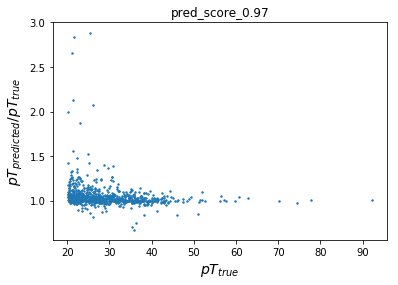

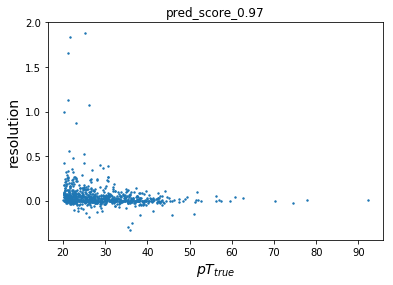

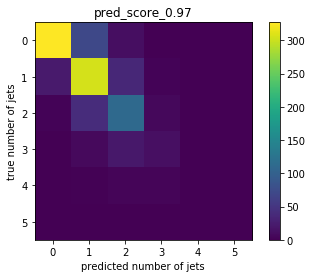

accuracy score: 0.759
F1 score: 0.7590000000000001


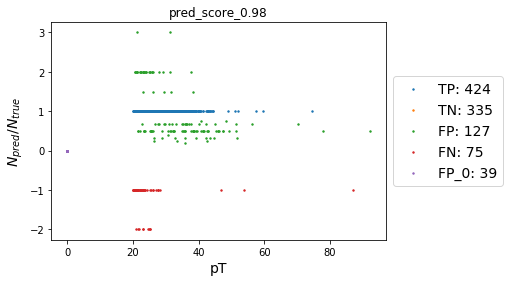

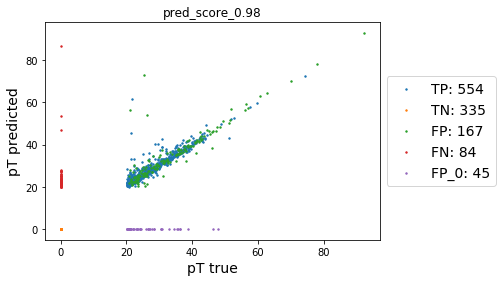

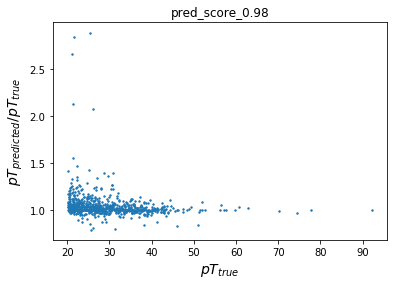

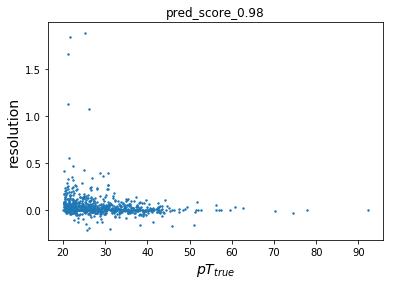

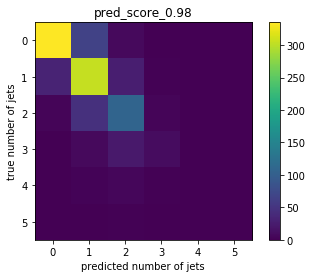

accuracy score: 0.759
F1 score: 0.7590000000000001


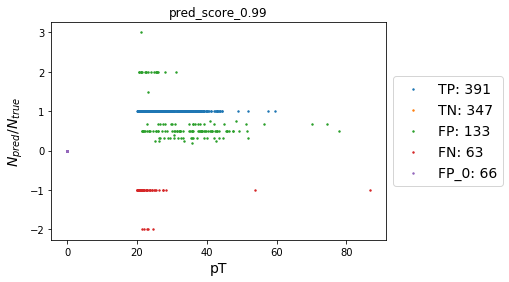

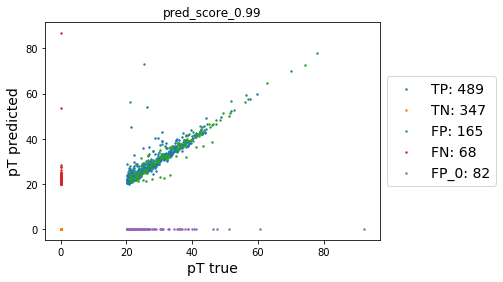

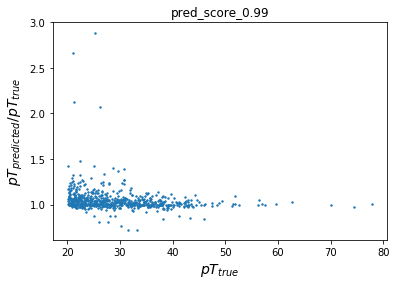

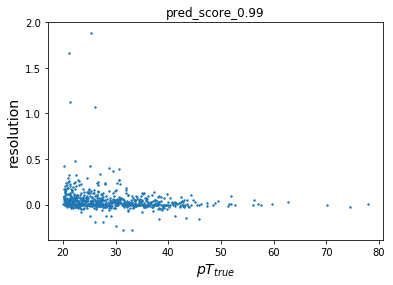

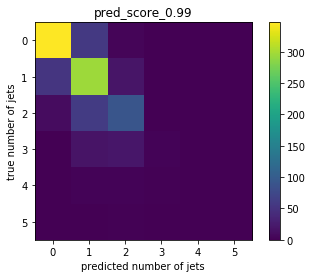

accuracy score: 0.738
F1 score: 0.738


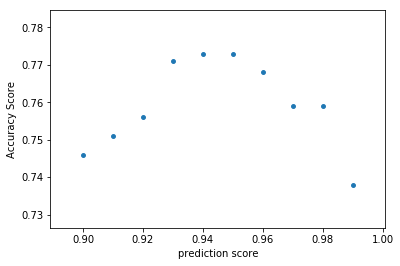

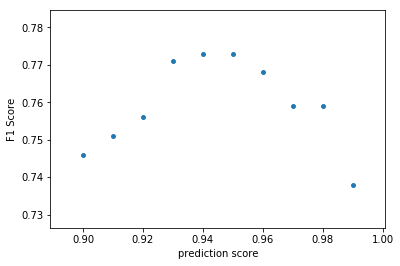

In [44]:
final_res = {}
x = []
y = []

x_f1 = []
y_f1 = []

for key in dict_weights1990_res:
    test = dict_weights1990_res[key]
    tp_x, tp_y, tn_x, tn_y, fp_x, fp_y, fn_x, fn_y, fp_x0, fp_y0 = plotNjets_Cases(test, key, s = 2)
    plot_pTjets_Cases(test, key, s = 2)
    plot_pT(test, key, s =2)
    make_cmat(test['cmat'], key)
    AS = get_accuracy_score(test)
    ff = get_f1_score(test)
    print('accuracy score: ' + str(AS))
    x.append(float(key[-3:]))
    y.append(AS)
    print('F1 score: ' + str(ff))
    x_f1.append(float(key[-3:]))
    y_f1.append(ff)
    
    
plt.figure()
plt.scatter(x, y, s = 15)
plt.ylabel('Accuracy Score')
plt.xlabel('prediction score')
plt.savefig('plot_accuracy_score.png', dpi = 600)
plt.show()

plt.figure()
plt.scatter(x_f1, y_f1, s = 15)
plt.ylabel('F1 Score')
plt.xlabel('prediction score')
plt.savefig('plot_F1_score.png', dpi = 600)
plt.show()
